In [56]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
#from textwrap import wrap
import textwrap

In [69]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        # Prepare df3/lookup for use
        
        # Make firt column lowercase
        df3['Exit Survey'] = df3['Exit Survey'].str.lower()
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Purchases'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='left')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge Spend and Lift to Lookup Tab;e
        lift_spend_df = pd.merge(lift_spend_df, df3[['Exit Survey','Airings']],left_on= ['Network'], right_on = ['Airings'], how='left')
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, on=['Year','Month','Exit Survey'], how='outer')
        monthly_stats['network_name'] = np.where(monthly_stats.TV_Network.isnull(),monthly_stats.Network,monthly_stats.TV_Network)
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Network','network_name','Purchases','Spend','Lift']]
        monthly_stats = monthly_stats[monthly_stats.Year.notna()]
        
        
        #monthly_stats['network_name'] = np.where(monthly_stats.TV_Network.isnull(),monthly_stats.Network,monthly_stats.TV_Network)
        
        return monthly_stats
    
    def get_metrics(self):
        # Get Monthly Stats Df
        monthly_stats = self.get_monthly_stats()
        
        # Compute Cost Per Visitor
        monthly_stats['cpv'] = np.where(monthly_stats.Spend.isnull(),0, np.where((monthly_stats.Purchases.isnull()),1000000,(monthly_stats.Spend/monthly_stats.Purchases)))
        
        # Compute Conversion Rate 
        monthly_stats['conversion_rate'] = monthly_stats['Purchases']/monthly_stats['Lift']
        
        # Compute Cost Per Acquisition
        monthly_stats['cpa'] = np.where(monthly_stats.Spend.isnull(),0, np.where((monthly_stats.Purchases.isnull()),1000000,(monthly_stats.Spend/monthly_stats.Purchases)))
        
        return monthly_stats
    
    def print_visuals(self, metrics):
        df = self.get_metrics()
    
        year_mons = []

        # Get number of plots need (one for each month of each year recorded)
        for year in monthly_stats['Year'].unique():
            for month in df[df['Year'] == year]['Month'].unique():
                year_mons.append([year, month])
            
        for metric in metrics:
            for i in range(len(year_mons)):
                # Create dataframe for plot
                vis_df = df[(df['Year'] == year_mons[i][0]) & (df['Month'] == year_mons[i][1])]
                # Sort values by metric
                vis_df = vis_df.sort_values(metric)
                # Clean Network Names
                vis_df.network_name = vis_df.network_name.map(lambda x: x.replace("_"," "))
                vis_df.network_name = vis_df.network_name.map(lambda x: x.title())
                labels = vis_df.network_name
                x_axis = range(len(labels))
                # Create Plot
                plt.figure(figsize = (30,10))
                # Adjust Y Axis Size
                real_metrics = vis_df[vis_df[metric] != 1000000]
                max_real_metric = max(real_metrics[metric])
                plt.ylim(0, max_real_metric*1.5)
                # Plot data
                sns.barplot(x='network_name',y=metric, data=vis_df, palette = ['crimson'])
                # CAP All Metric Name
                cap_metric = metric.replace("_"," ")
                cap_metric = metric.upper()
                # Get Month Name (String)
                datetime_object = datetime.datetime.strptime(str(year_mons[i][1]), "%m")
                month_name = datetime_object.strftime("%B")
                # Title
                plt.title(cap_metric +' - ' + month_name + ', ' + str(year_mons[i][0]) , fontsize=35)
                # X Axis Label
                plt.xlabel('Network', fontsize=24)
                # Y Axis Label
                plt.ylabel(cap_metric, fontsize=24)
                # X Ticks
                plt.xticks(x_axis, [textwrap.fill(label, 12) for label in labels],fontsize=14, rotation=60)
                plt.yticks(fontsize=18)

In [70]:
test = Final('Analyst_Dataset.xlsx')

In [71]:
monthly_stats = test.get_metrics()
monthly_stats

<ipython-input-69-e29a83de64db>:60: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


,Year,Quarter,Month,TV_Network,Network,network_name,Purchases,Spend,Lift,cpv,conversion_rate,cpa
0,2017,Q3,9,aapka_colors,NaN,aapka_colors,1.0,NaN,NaN,0.000000,NaN,0.000000
1,2017,Q3,9,baby_first,NaN,baby_first,1.0,NaN,NaN,0.000000,NaN,0.000000
2,2017,Q3,9,bloomberg,BLOM,bloomberg,1.0,4966.72,199.0,4966.720000,0.005025,4966.720000
3,2017,Q3,9,cbs_sports,NaN,cbs_sports,1.0,NaN,NaN,0.000000,NaN,0.000000
4,2017,Q3,9,cnbc,CNBC,cnbc,5.0,6481.42,406.0,1296.284000,0.012315,1296.284000
5,2017,Q3,9,cnn,CNN,cnn,13.0,9159.60,507.0,704.584615,0.025641,704.584615
6,2017,Q3,9,dish_network,DISH,dish_network,4.0,2513.09,976.0,628.272500,0.004098,628.272500
7,2017,Q3,9,diy,NaN,diy,2.0,NaN,NaN,0.000000,NaN,0.000000
8,2017,Q3,9,fox_news,NaN,fox_news,5.0,NaN,NaN,0.000000,NaN,0.000000
9,2017,Q3,9,fox_sports,FS1,fox_sports,1.0,4258.50,183.0,4258.500000,0.005464,4258.500000


<ipython-input-69-e29a83de64db>:60: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


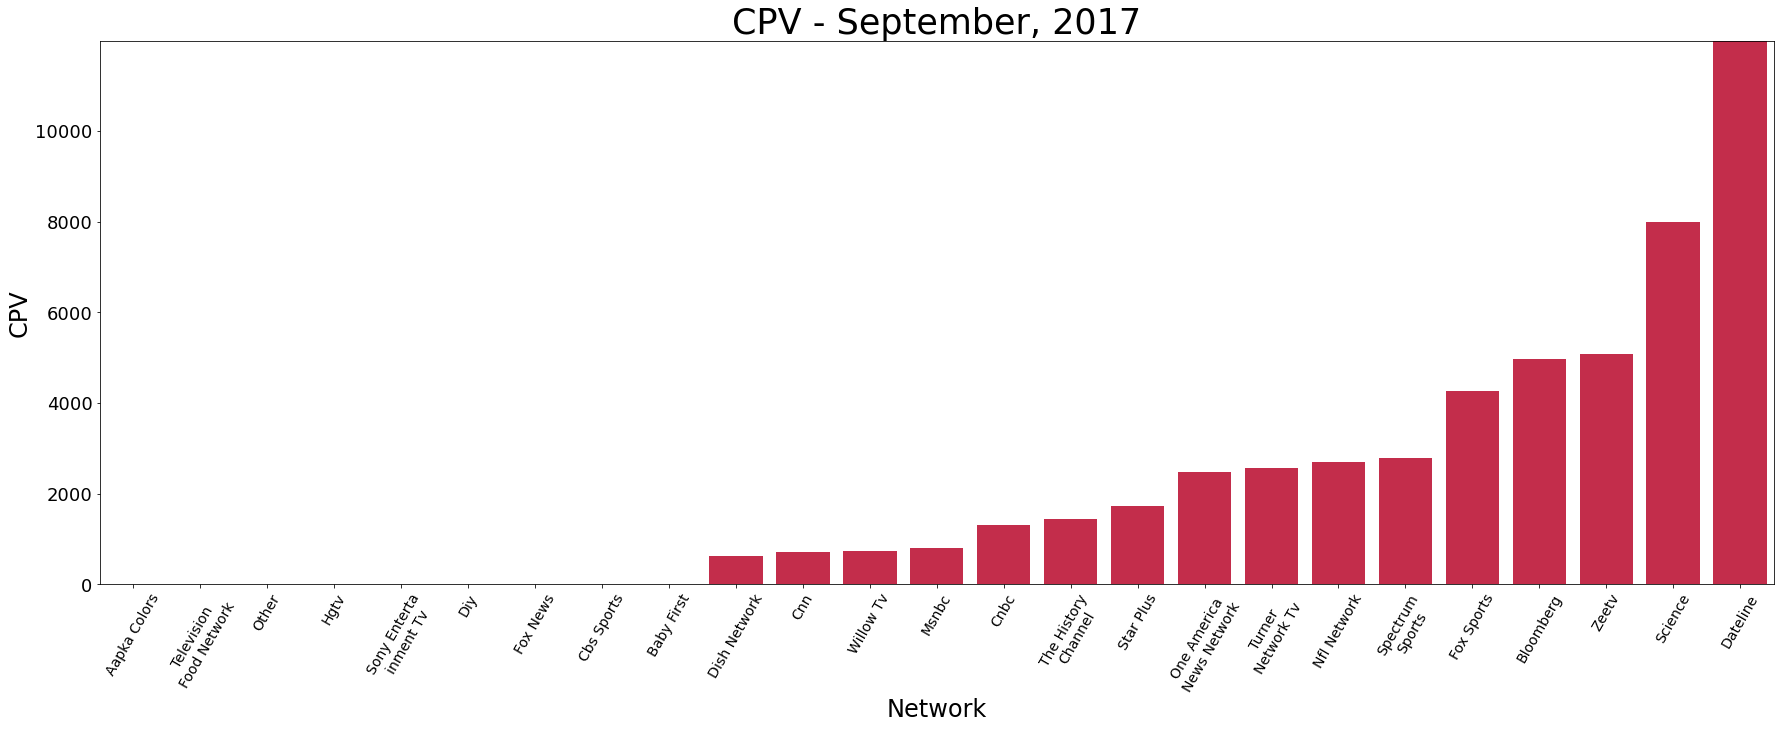

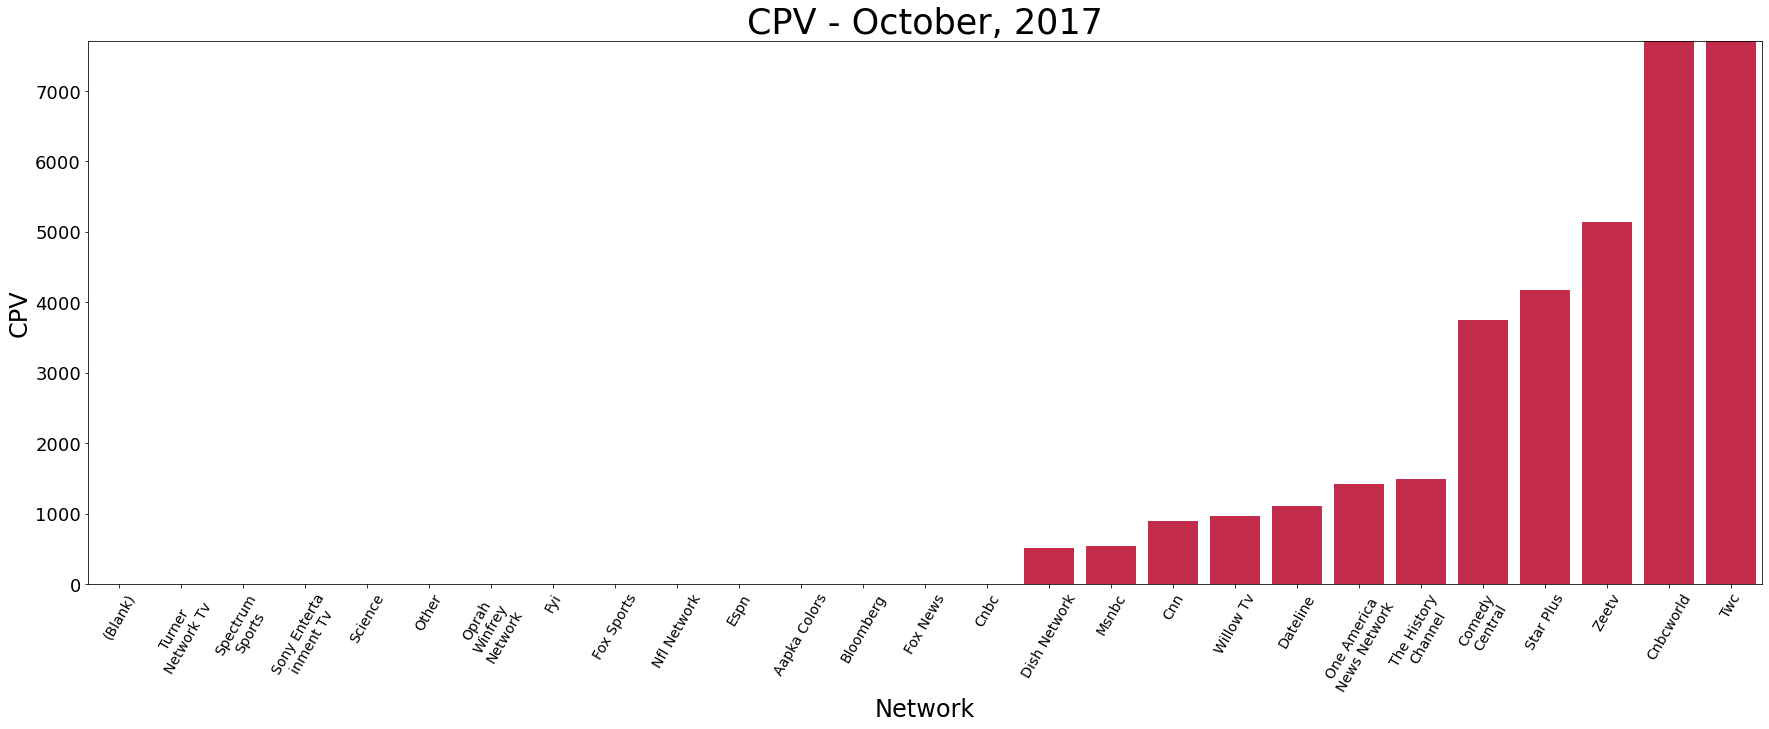

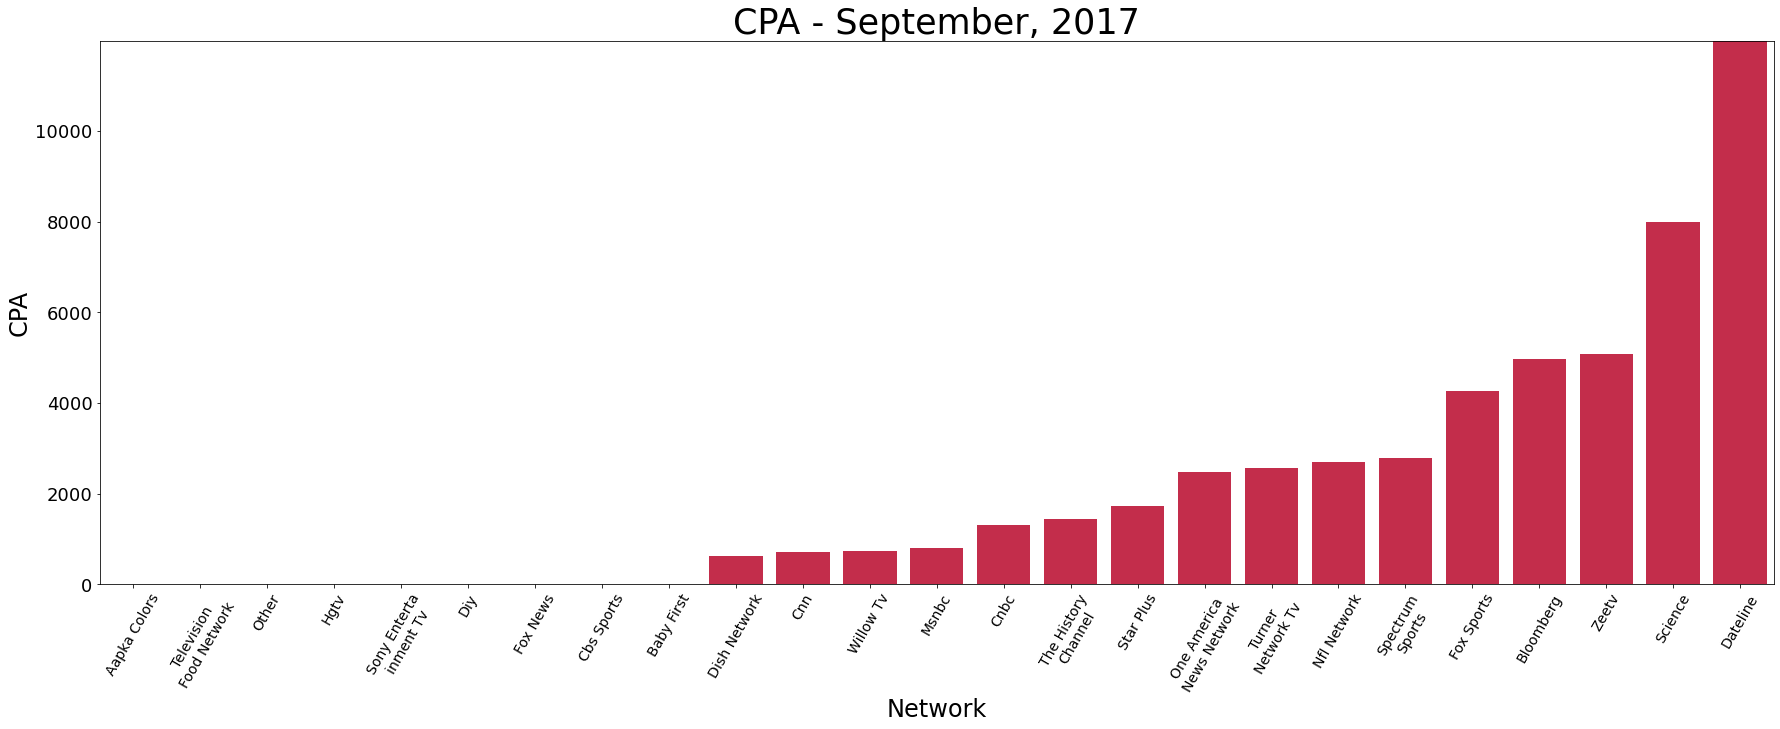

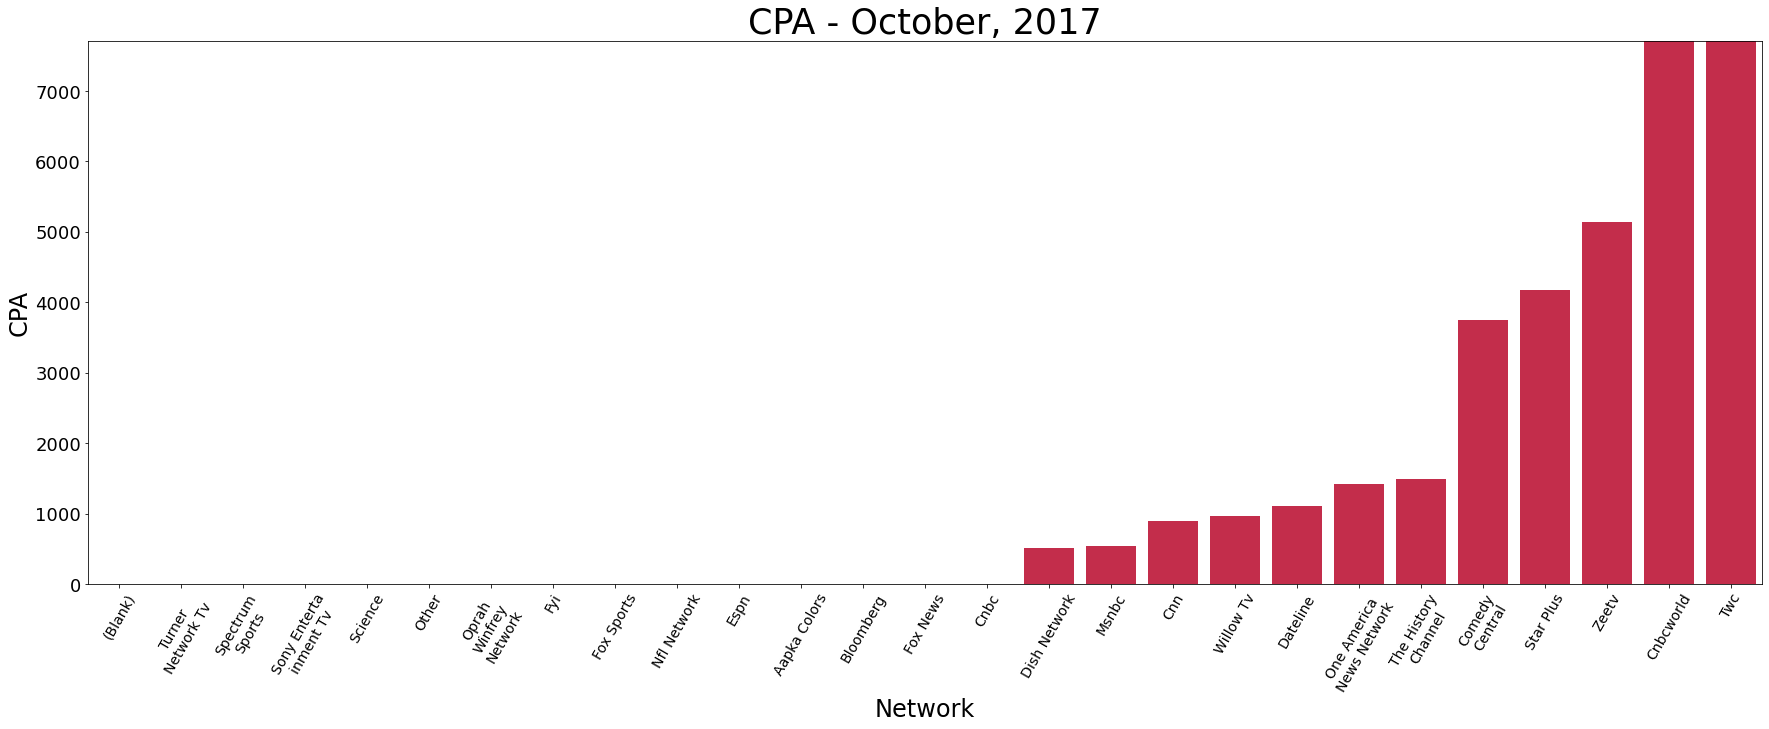

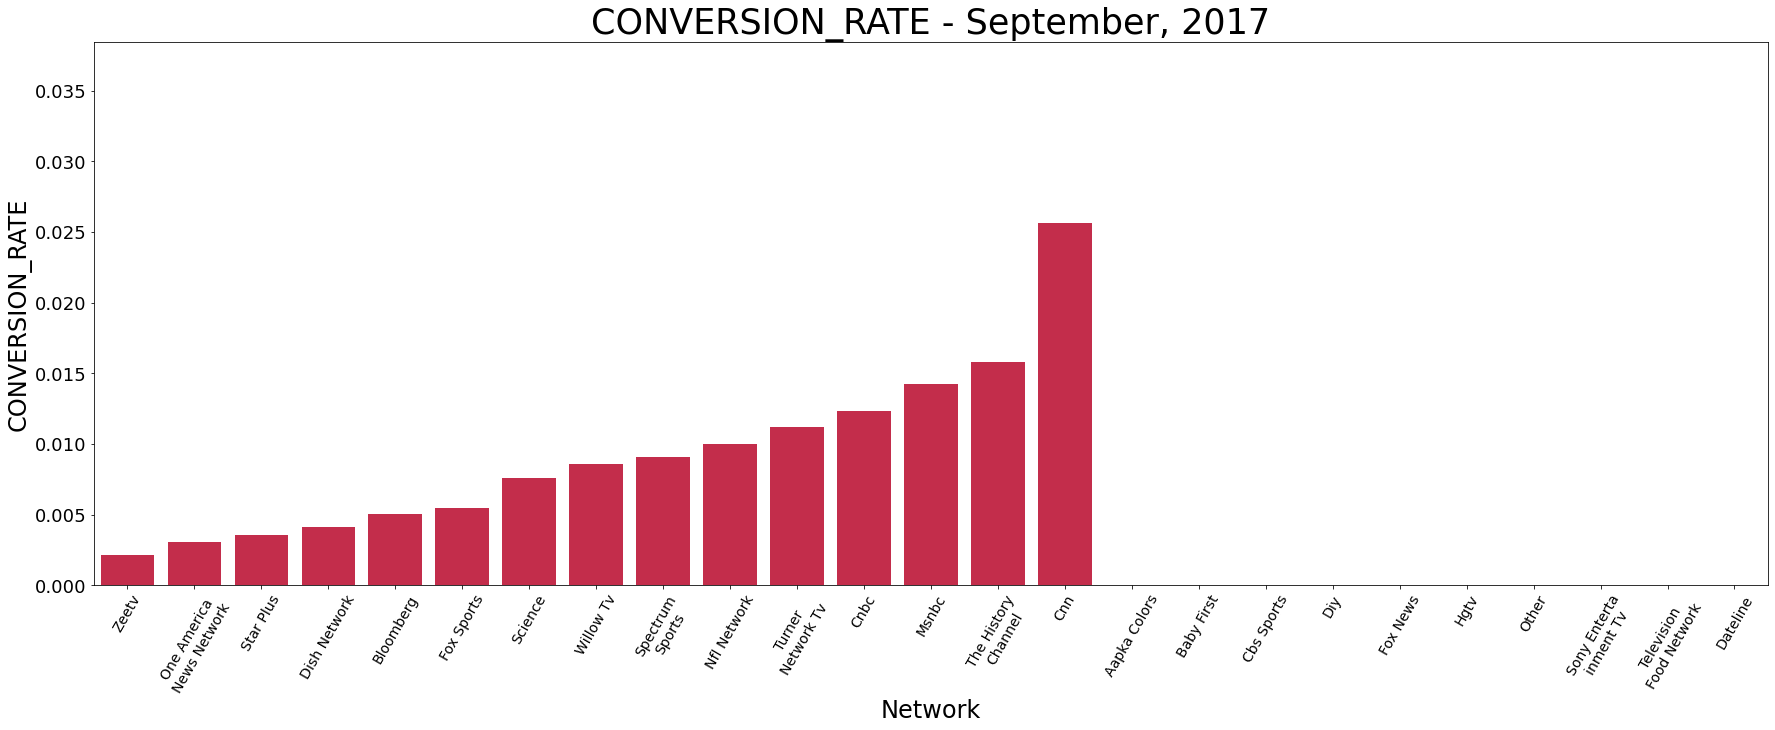

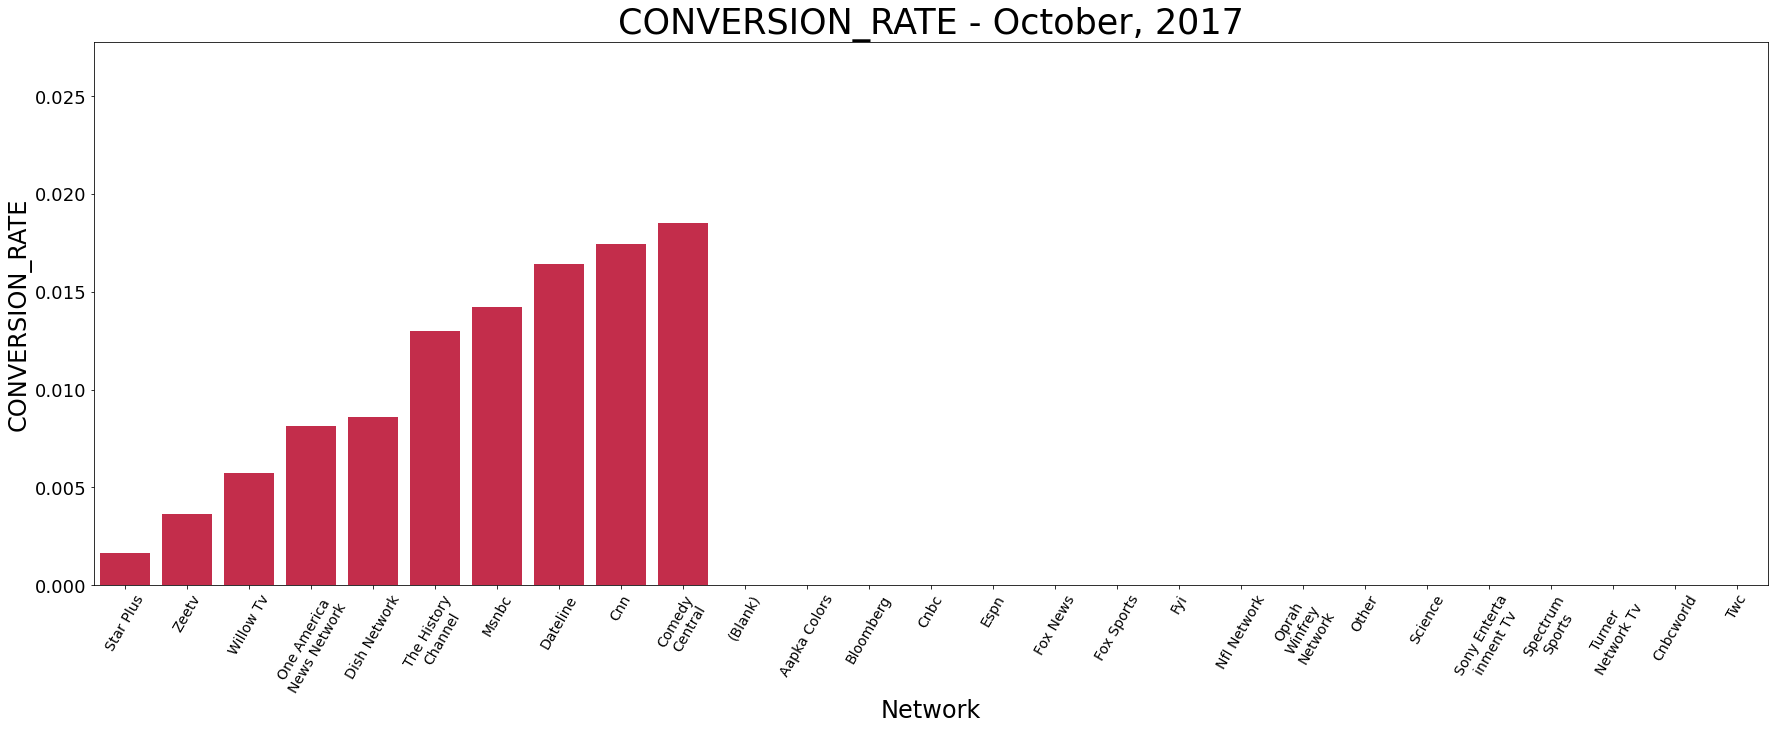

In [72]:
test.print_visuals(['cpv','cpa','conversion_rate'])

In [ ]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        # Prepare df3/lookup for use
        
        # Make firt column lowercase
        df3['Exit Survey'] = df3['Exit Survey'].str.lower()
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Purchases'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='left')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge Spend and Lift to Lookup Tab;e
        lift_spend_df = pd.merge(lift_spend_df, df3[['Exit Survey','Airings']],left_on= ['Network'], right_on = ['Airings'], how='left')
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, on=['Year','Month','Exit Survey'], how='outer')
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Network','Purchases','Spend','Lift']]
        monthly_stats = monthly_stats[monthly_stats.Year.notna()]
        
        
        
        return monthly_stats
    
    def get_metrics(self):
        # Get Monthly Stats Df
        monthly_stats = self.get_monthly_stats()
        
        # Compute Cost Per Visitor
        monthly_stats['cpv'] = np.where(df.Spend.isnull(),0, np.where((df.Purchases.isnull()),1000000,(df.Spend/df.Purchases)))
        
        # Compute Conversion Rate 
        monthly_stats['conversion_rate'] = monthly_stats['Purchases']/monthly_stats['Lift']
        
        # Compute Cost Per Acquisition
        monthly_stats['cpa'] = np.where(df.Spend.isnull(),0, np.where((df.Purchases.isnull()),1000000,(df.Spend/df.Purchases)))
        
        return monthly_stats
    

In [ ]:
monthly_stats = test.get_metrics()

In [ ]:
monthly_stats

In [ ]:
test.print_visuals(['cpv','cpa','conversion_rate'])

# Cost Per Vistor 

The Cost Per Vistor is the total dollar amount spent per visit to a company's website/physical location. In order to compute the Cost Per Vistor, the number of visitors to a company website/physical location needs to be recorded. Company XYZ only has records from people who have made a purchase. If the number of survey recordings (which is also equivalent to the number of sales made) is used in place of total visits, the Cost Per Visit calculated will be incorrect. If the Cost Per Visit were to be computed with the existing data, it would be equivalent to the Cost Per Acquisition.

# Cost Per Acquisition

In [ ]:
monthly_stats.head()

In [ ]:
def compare_months(month1,year1,month2,year2,metric):
    

In [ ]:
real = monthly_stats[monthly_stats.cpv != 1000000]
max(real.cpv)

In [ ]:
test = []

for year in monthly_stats['Year'].unique():
    for month in df[df['Year'] == 2017]['Month'].unique():
        test.append([year, month])
        df.bar(x='TV_Network',y='cpa')
        
for i in range(len(test)):
    
    print(i)

print(test)
    #monthly_stats['Month'].unique().sort(
    #print(year)

In [ ]:
plt.bar(10,monthly_stats.cpa)

In [ ]:
fig, ax = pyplot.subplots(figsize=(20,6))
ax.bar(monthly_stats.cpa)
#sns.set_style('white',{'axes.edgecolor': '.9'},)
#monthly_stats['cpa'].value_counts().plot(kind='barh',color='hotpink',edgecolor='gray', title='BOOK RATING COUNTS')
#fig.show()
#ax.set(xlabel='Rating Count', ylabel='Number of Stars')

In [ ]:
#df['d'] = np.where(df.a.isnull(),np.nan, np.where((df.b == "N")&(~df.c.isnull()),df.a*df.c,df.a))

df['test'] = np.where(df.Spend.isnull(),0, np.where((df.Purchases.isnull()),10000,(df.Spend/df.Purchases)))

#df['test'] = np.where((df.Lift >= 0)&(df.Spend.isnull()), df.Spend/df.Lift, 0)

In [ ]:
df.head()

In [ ]:
spend is nan and purchases >= 1 then cpv is 0

In [ ]:
df.head()